In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function

import os.path
import sys
import time

import urllib

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Environments

In [2]:

"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.13.1


# Load Data

In [3]:
"""
references:  stanford cs231n assignment2
"""

from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape:         ', X_train.shape)
print('Train labels shape:       ', y_train.shape)
print('Validation data shape:    ', X_val.shape)
print('Validation labels shape:  ', y_val.shape)
print('Test data shape:          ', X_test.shape)
print('Test labels shape:        ', y_test.shape)
print('X_train.dtype:            ', X_train.dtype)
print('y_train.dtype:            ', y_train.dtype)

Train data shape:          (49000, 32, 32, 3)
Train labels shape:        (49000,)
Validation data shape:     (1000, 32, 32, 3)
Validation labels shape:   (1000,)
Test data shape:           (10000, 32, 32, 3)
Test labels shape:         (10000,)
X_train.dtype:             float64
y_train.dtype:             int64


# Visualize Examples

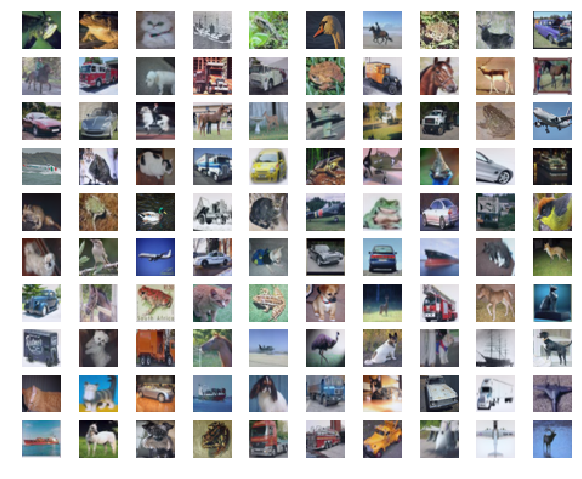

In [28]:
img = X_train[np.random.randint(0, 49000, size = 100), :]
img_max, img_min = np.max(img), np.min(img)
img = 255.0 * (img - img_min) / (img_max - img_min)
img = img.astype('uint8')

    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(img[i * 10 + j, :])
        plt.gca().axis('off')
        
plt.show()

# Model

In [4]:
def weight_variable_reg(shape, stddev, reg):
    var = tf.Variable(tf.truncated_normal(shape, stddev = stddev))
    if reg is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var), reg, name = 'weight_loss')
        tf.add_to_collection('losses', weight_loss)
    return var

def my_model(X):

    F1 = 3
    F2 = 64
    Wconv1 = weight_variable_reg([3, 3, F1, F2], stddev=1.0e-2, reg=0.0)
    bconv1 = tf.Variable(tf.zeros([F2]))
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding='SAME') + bconv1
    h1 = tf.nn.relu(a1)      

  
    h_pool1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    shape = [16 * 16 * 64, 10]
    W1 = weight_variable_reg(shape, stddev=1.0e-2, reg=0.0)   
    b1 = tf.Variable(tf.zeros([10]))

    h_pool1_flat = tf.reshape(h_pool1, [-1, 16*16*64])
    a2 = tf.matmul(h_pool1_flat, W1) + b1
    
    y_out = tf.nn.relu(a2)
    
   
    return y_out

def data_next_batch(indicies, data_set, label_set, i):
    """
    Args:
        indicies:  The shuffled indexes of training data_set 
        data_set:  images from cifar10  
        label_set: labels from cifar10
        i        : the ith batch data
        
    Returns:
        images and labels for feed_dict
       
    """
    start_idx = (i * configs.batch_size) % data_set.shape[0]
    end_idx = np.min([start_idx + configs.batch_size, data_set.shape[0]])
    
    idx = indicies[start_idx : end_idx]
    
    
    return data_set[idx, :], label_set[idx]

def evaluation(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    correct = tf.nn.in_top_k(logits, labels, 1)
    
    
    return tf.reduce_mean(tf.cast(correct, tf.float32))


def num_correct_pred(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    correct = tf.nn.in_top_k(logits, labels, 1)
    
    
    return tf.reduce_sum(tf.cast(correct, tf.float32))              

# Graph

In [5]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])


class configs:
    batch_size = 128
    learning_rate = 1e-3
    print_every = 50
    epochs = 1
    model_path_name = "./models/my_model.ckpt"
    
    
## loss
y_out = my_model(X)
accuracy = evaluation(y_out, y)
correct_num = num_correct_pred(y_out, y)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = y_out, labels = tf.one_hot(y,10))
mean_loss = tf.reduce_mean(cross_entropy)

## train
train_step = tf.train.AdamOptimizer(configs.learning_rate).minimize(mean_loss) 

saver = tf.train.Saver()

# Training

Iter         1, train loss 3.64673, training batch accuracy 0.125
Iter        51, train loss 2.30259, training batch accuracy 1
Iter       101, train loss 2.30259, training batch accuracy 1
Iter       151, train loss 2.30259, training batch accuracy 1
Iter       201, train loss 2.30259, training batch accuracy 1
Iter       251, train loss 2.30259, training batch accuracy 1
Iter       301, train loss 2.30259, training batch accuracy 1
Iter       351, train loss 2.30259, training batch accuracy 1
Epoch 1, Overall validation loss = 2.30258512497, validation acuracy = 1.00000011921
Epoch 1, best validation accuracy = 1.00000011921


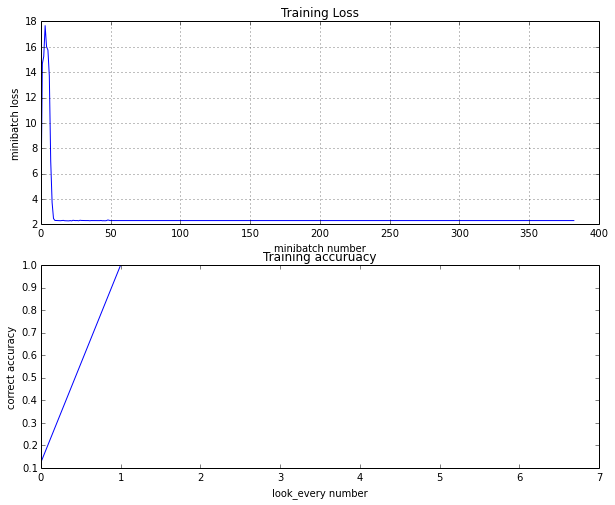

test set accuracy:    1.0


In [6]:
init = tf.global_variables_initializer()

sess = tf.Session()
with tf.device("/gpu:0") as dev:
    sess.run(init)
 
    iter_cnt = 1
    best_val_acc = -1
    for e in range(configs.epochs):
        validing_now = False
        
        train_indicies = np.arange(X_train.shape[0])
        np.random.shuffle(train_indicies)

        losses = []
        train_accuracies = []    
        for i in range(int(math.ceil(X_train.shape[0] * 1.0 / configs.batch_size))):
            batch_X, batch_y = data_next_batch(train_indicies, X_train, y_train, i)    
                 
            loss, _ = sess.run([mean_loss, train_step], feed_dict={X: batch_X, y: batch_y})
            losses.append(loss)
            
            if i % configs.print_every == 0:
                train_accuracy = sess.run(accuracy, feed_dict = {X: batch_X, y: batch_y})
                train_accuracies.append(train_accuracy)
                print('Iter %9d, train loss %g, training batch accuracy %g' % (iter_cnt, loss, train_accuracy))
         
            
            iter_cnt += 1
            
        validing_now = True    
        if validing_now:
            feed_val_dict = {X: X_val, y: y_val} 
            val_loss, val_acc = sess.run([mean_loss, accuracy], feed_dict = feed_val_dict)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                saver.save(sess, configs.model_path_name)

            print("Epoch {2}, Overall validation loss = {0}, validation acuracy = {1}".format(val_loss, val_acc, e+1))
            print("Epoch {1}, best validation accuracy = {0}".format(best_val_acc, e+1))
                                                      
        ## visualizing loss and accuracy 
        plt.subplot(2, 1, 1)
        plt.plot(losses)
        plt.grid(True)
        plt.title('Training Loss')
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
    
        plt.subplot(2, 1, 2)
        plt.plot(train_accuracies)
        plt.title("Training accuruacy")
        plt.xlabel("look_every number")
        plt.ylabel("correct accuracy")
    
    
        plt.show()    
        
    ## load the best model
    saver.restore(sess, configs.model_path_name)
    
    acc = 0.0
    test_indicies = np.arange(X_test.shape[0])
    for j in range(X_test.shape[0]//100):
        batch_X = X_test[j*100: (j+1)*100]
        batch_y = y_test[j*100: (j+1)*100] 
        feed_dict = {X: batch_X, y: batch_y}
        
        _acc = sess.run(correct_num, feed_dict=feed_dict)
        acc += _acc

    test_acc = 1.0 * acc / X_test.shape[0]       
        
    print("test set accuracy:   ", test_acc)

# Bug